In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import requests
from urllib.parse import quote
import concurrent.futures

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from current font")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

In [2]:
data = pd.read_csv('data/train_2.csv')
data.rename(columns={
    'Page': 'page'
}, inplace=True)
data.shape

(145063, 804)

In [3]:
def extract_page_components(page_name):
    parts = page_name.split('_')
    agent = parts.pop()
    access = parts.pop()
    domain = parts.pop()
    locale = domain.split('.')[0]
    article = '_'.join(parts)
    return article, domain, locale, access, agent

def extract_main_domain(domain):
    if 'wikipedia' in domain:
        return 'wikipedia'
    elif 'wikimedia' in domain:
        return 'wikimedia'
    elif 'mediawiki' in domain:
        return 'mediawiki'
    else:
        return 'other'

data[['article', 'domain', 'locale', 'access', 'agent']] = data['page'].apply(lambda x: pd.Series(extract_page_components(x)))
data['main_domain'] = data['domain'].apply(extract_main_domain)

In [4]:
cols = ['article', 'main_domain', 'domain', 'locale', 'access', 'agent'] + [col for col in data.columns if col not in ['article', 'main_domain', 'domain', 'locale', 'access', 'agent']]
data = data[cols]

In [5]:
def visualize_value_counts(df, column, title, horizontal=False, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    if horizontal:
        sns.countplot(data=df, y=column, order=df[column].value_counts().index)
    else:
        sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(column.capitalize())
    # plt.grid(True)
    plt.show()

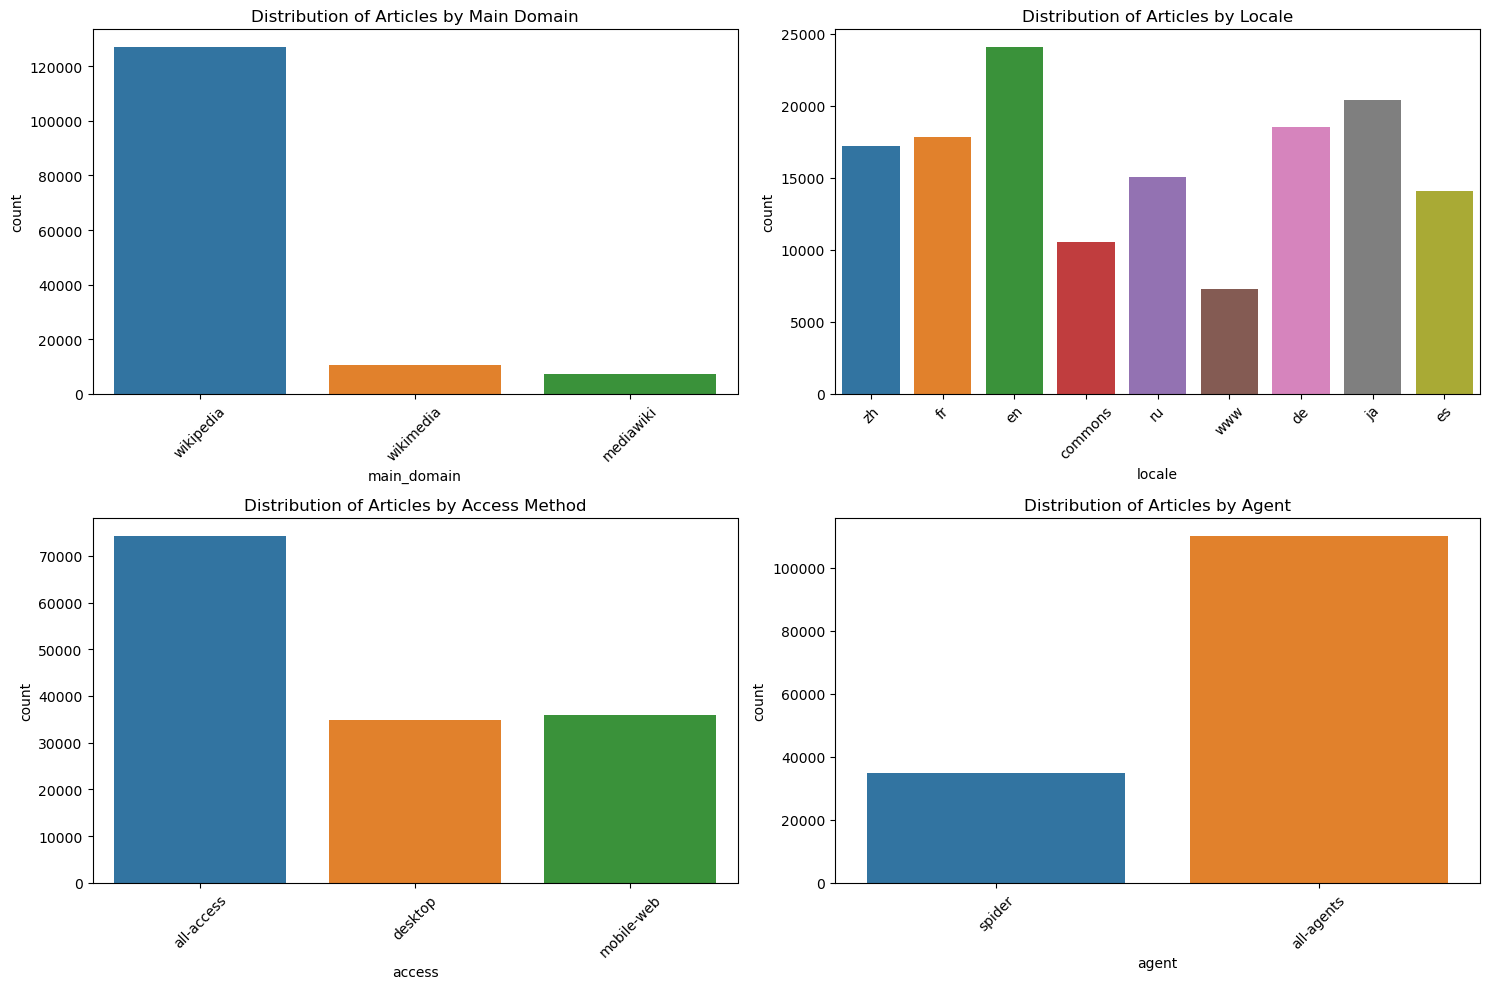

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(data=data, x='main_domain', ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Articles by Main Domain')
axs[0, 0].tick_params(axis='x', rotation=45)

sns.countplot(data=data, x='locale', ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Articles by Locale')
axs[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(data=data, x='access', ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Articles by Access Method')
axs[1, 0].tick_params(axis='x', rotation=45)

sns.countplot(data=data, x='agent', ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Articles by Agent')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

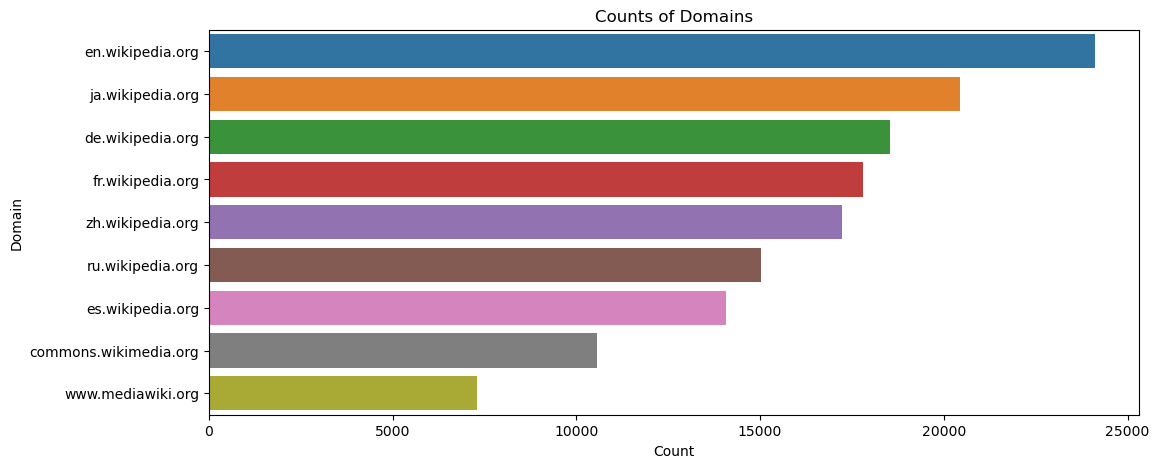

In [7]:
visualize_value_counts(data, 'domain', 'Counts of Domains', horizontal=True, figsize=(12, 5))

### View Count Values

In [33]:
date_columns = data.filter(regex=r'\d{4}-\d{2}-\d{2}').columns

In [8]:
date_columns = data.filter(regex=r'\d{4}-\d{2}-\d{2}').columns
all_view_counts = data[date_columns].values.flatten().astype(float)

description = pd.Series(all_view_counts[~pd.isna(all_view_counts)]).describe()

print(f"Count: {description['count']:.0f}")
print(f"Mean: {description['mean']:.2f}")
print(f"Standard Deviation: {description['std']:.2f}")
print(f"Min: {description['min']:.2f}")
print(f"25%: {description['25%']:.2f}")
print(f"50% (Median): {description['50%']:.2f}")
print(f"75%: {description['75%']:.2f}")
print(f"Max: {description['max']:.2f}")

Count: 109458241
Mean: 1360.77
Standard Deviation: 82365.08
Min: 0.00
25%: 19.00
50% (Median): 145.00
75%: 646.00
Max: 67264258.00


### Missing Values

**Handling NaNs**: 
  - **NaNs as 0s**: Generally, NaNs can be treated as 0s (no views).
  - **High NaNs**: Articles with NaNs for almost all days should be scrutinized or potentially excluded from analysis.

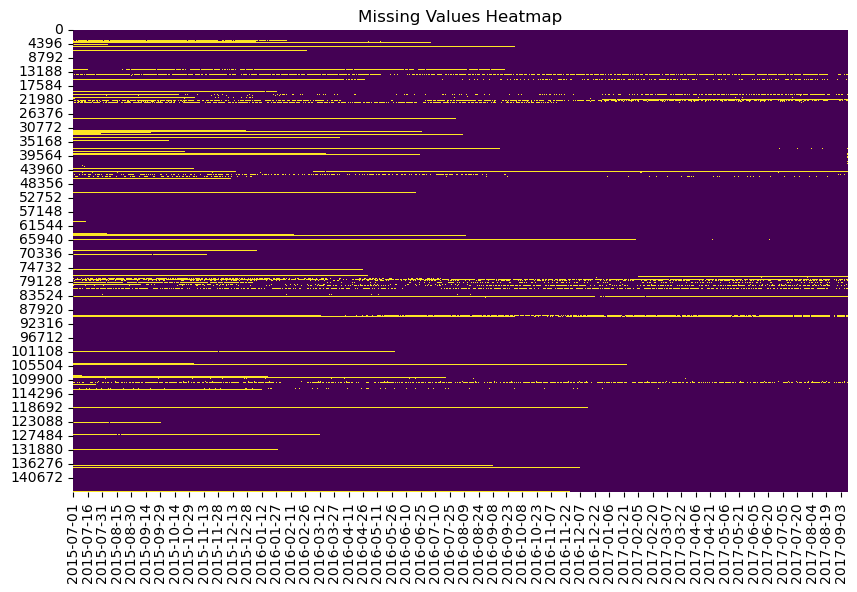

In [9]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(data[date_columns].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

The heatmap visualizes missing values in the dataset. Each row represents an article, and each column represents a date.

1. **Pattern of Missing Values**:
   - Some articles have continuous blocks of missing values.
   - Sparse missing values are scattered across various articles.

2. **Consecutive NaNs at the End**:
   - Many articles have missing values towards the end of the time series, indicating recent data might be incomplete.

3. **Extent of Missing Values**:
   - There is significant variation in the extent of missing data across articles.
   - Some articles have very few missing values, while others have substantial gaps.

### Implications for Analysis
- Articles with significant missing data need special attention during preprocessing.
- Handling missing values (imputation or exclusion) will be crucial for accurate forecasting.

In [10]:
# data[date_columns] = data[date_columns].astype('Int64')

data['total_nans'] = data[date_columns].isna().sum(axis=1)

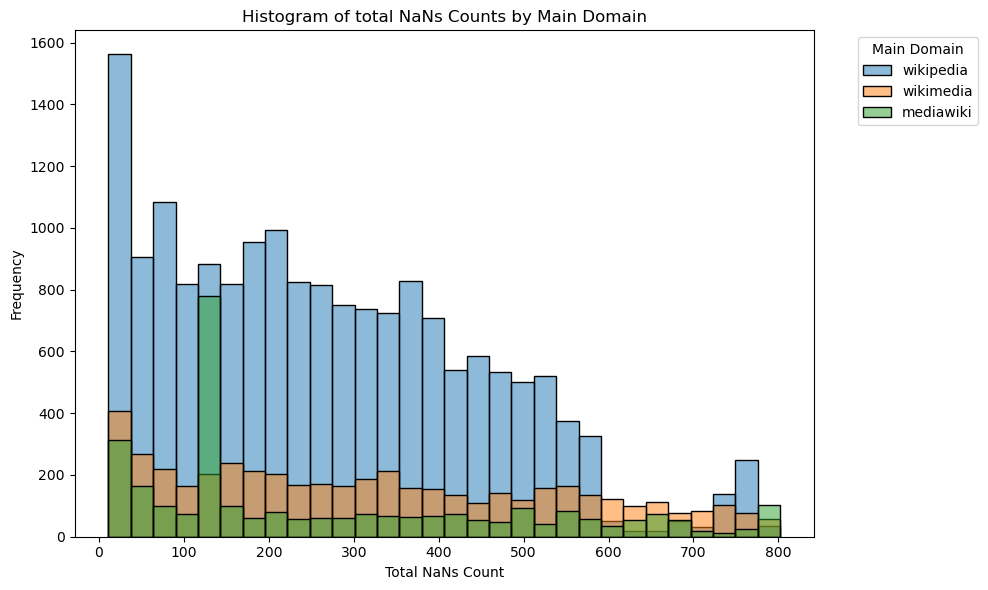

In [11]:
plt.figure(figsize=(10, 6))

main_domains = data['main_domain'].unique()
for main_domain in main_domains:
    subset = data[(data['main_domain'] == main_domain) & (data['total_nans'] > 10)]
    sns.histplot(subset['total_nans'], label=main_domain, kde=False, bins=30, alpha=0.5)

plt.title('Histogram of total NaNs Counts by Main Domain')
plt.xlabel('Total NaNs Count')
plt.ylabel('Frequency')
plt.legend(title='Main Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- **General Observation**: All three domains (`wikipedia`, `wikimedia`, `mediawiki`) have NaNs in their view counts.
- **Concern**: A significant number of pages have more than 500 days of NaNs, indicating potential data quality issues for those pages.

#### Implications:
- **Data Handling**: NaNs generally indicate 0 views but pages with extensive NaNs (e.g., more than 500 days) should be carefully reviewed or excluded from analysis.

In [12]:
rows_to_remove = data[data['total_nans'] > 500]
num_rows_to_remove = len(rows_to_remove)
total_rows = len(data)
proportion_to_remove = num_rows_to_remove / total_rows * 100

print(f"Number of rows to remove: {num_rows_to_remove}")
print(f"Total rows in dataset: {total_rows}")
print(f"Proportion of rows to remove: {proportion_to_remove:.2f}%")

Number of rows to remove: 3829
Total rows in dataset: 145063
Proportion of rows to remove: 2.64%


In [13]:
data = data[data['total_nans'] <= 500]

### Identify Continuous Missing Data (Recently):

Let's first check for consecutive NaNs at the end of each series and exclude those above a certain threshold. This approach ensures to focus on pages with substantial and recent missing data, which could significantly impact the analysis.

* For each page (row), let's count the number of consecutive NaN values at the end of the traffic data columns.
* Let's summarize and analyze the number of consecutive NaNs towards the end to identify potentially inactive pages.

In [14]:
def count_consecutive_nans_at_end(row):
    consecutive_nans = 0
    for value in reversed(row.tolist()):
        if pd.isna(value):
            consecutive_nans += 1
        else:
            break
    return consecutive_nans

data['consecutive_nans_at_end'] = data[date_columns].apply(count_consecutive_nans_at_end, axis=1)

In [15]:
data[data['consecutive_nans_at_end'] > 0]['consecutive_nans_at_end'].describe()

count    3592.000000
mean       13.674276
std        59.200241
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       491.000000
Name: consecutive_nans_at_end, dtype: float64

In [16]:
total_articles = len(data)
affected_articles = len(data[data['consecutive_nans_at_end'] > 100])
proportion_affected = affected_articles / total_articles * 100

print(f"Total articles: {total_articles}")
print(f"Articles with more than 100 NaNs at the end of the series: {affected_articles}")
print(f"Proportion: {proportion_affected:.2f}%")

Total articles: 141234
Articles with more than 100 NaNs at the end of the series: 149
Proportion: 0.11%


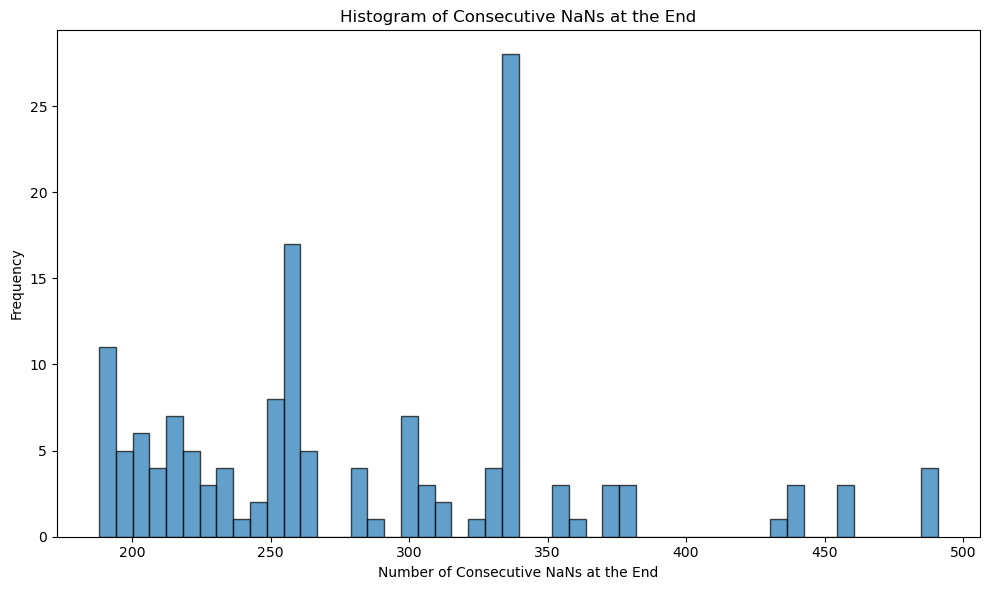

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(data[data['consecutive_nans_at_end'] > 100]['consecutive_nans_at_end'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Consecutive NaNs at the End')
plt.xlabel('Number of Consecutive NaNs at the End')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

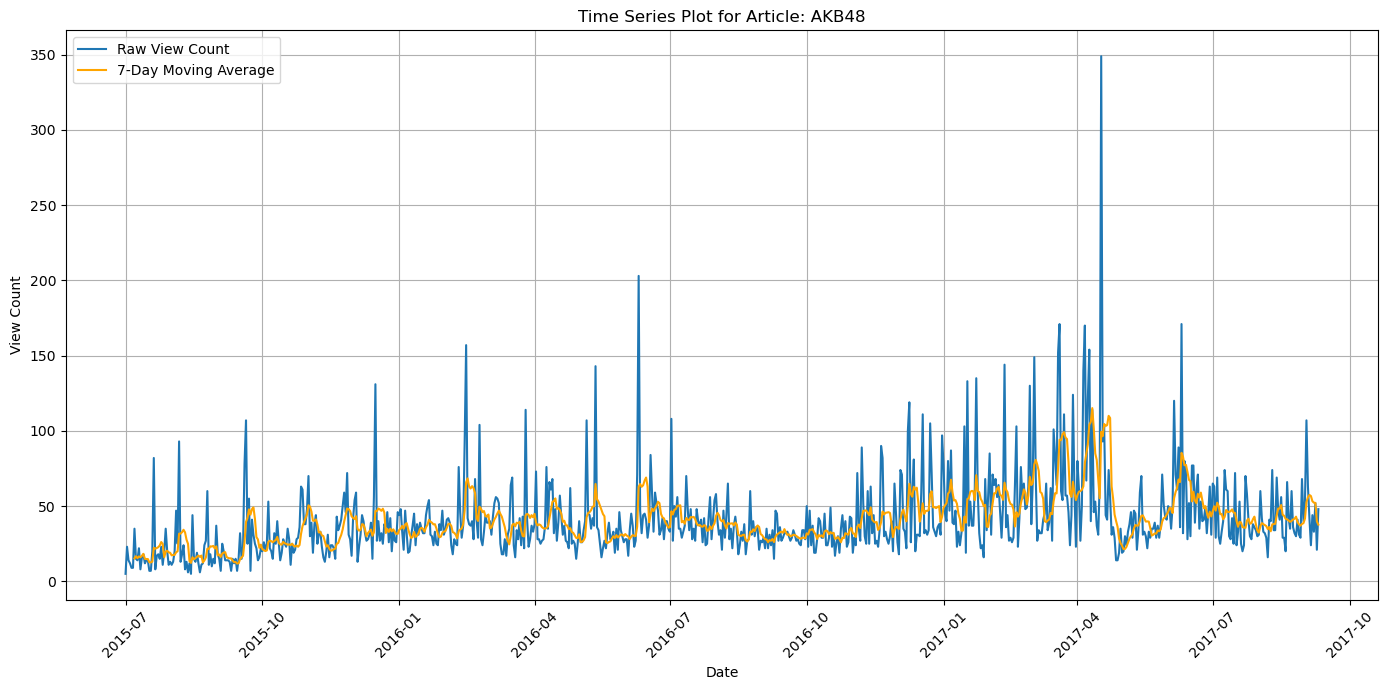

In [18]:
def plot_time_series(data, date_columns, row_number=None, window_size=7, aggregated=False, title=''):
    """
    Plots the time series for a given row number from the dataframe.
    
    Parameters:
        row_number (int): The row number of the article to be plotted.
    """
    if aggregated:
        dates = pd.to_datetime(data.index)
        views = data.values
        if not title:
            title = 'Aggregated View Count'
    else:
        sample_article = data.iloc[row_number]
        dates = pd.to_datetime(date_columns)
        views = sample_article[date_columns].values
        if not title:
            title = f'Time Series Plot for Article: {sample_article["article"]}'

    # Create a dataframe for plotting
    plot_data = pd.DataFrame({'Date': dates, 'Views': views})
    plot_data['Moving_Avg'] = plot_data['Views'].rolling(window=window_size).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(plot_data['Date'], plot_data['Views'], linestyle='-', label='Raw View Count')
    plt.plot(plot_data['Date'], plot_data['Moving_Avg'], color='orange', linestyle='-', label=f'{window_size}-Day Moving Average')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('View Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    
plot_time_series(data, date_columns, row_number=8)

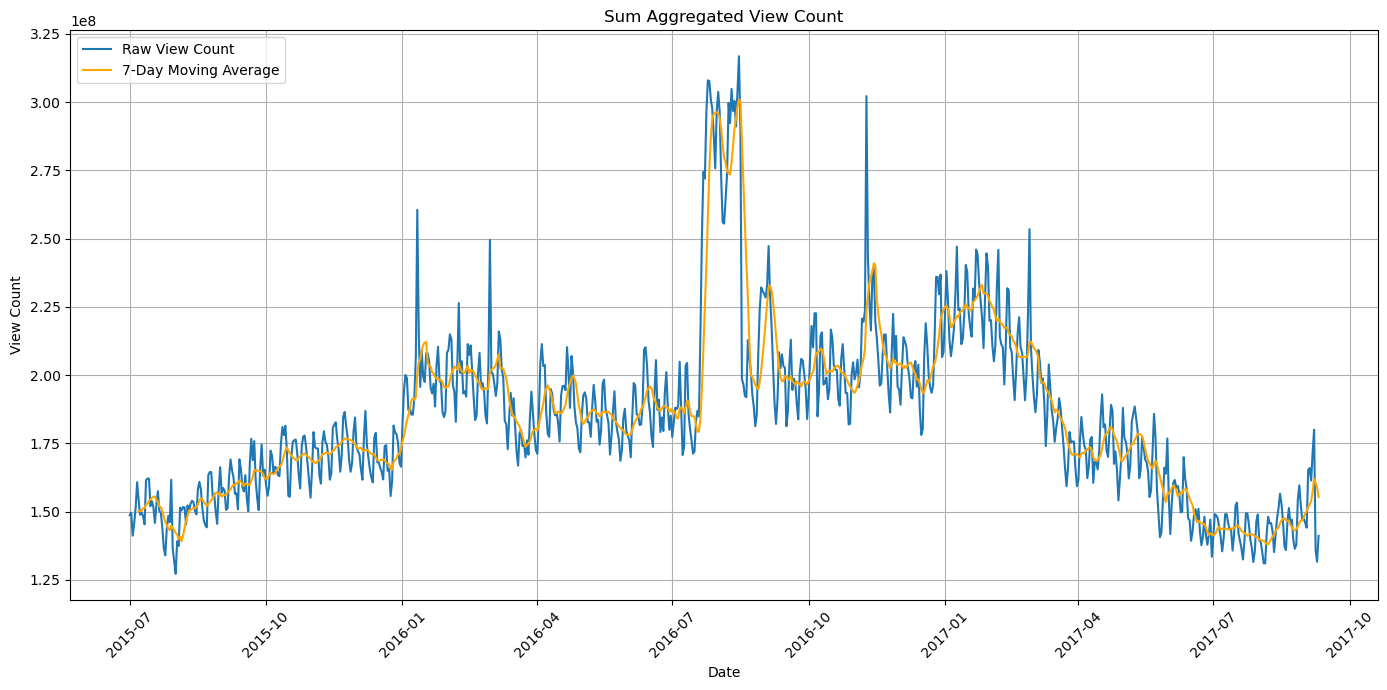

In [19]:
data_melted = data[['page'] + date_columns.to_list()].melt(id_vars=['page'], var_name='Date', value_name='View_Count')
data_melted['Date'] = pd.to_datetime(data_melted['Date'])

sum_aggregated_data = data_melted.groupby('Date')['View_Count'].sum()
plot_time_series(sum_aggregated_data, date_columns=None, aggregated=True, title='Sum Aggregated View Count')

- **Seasonal Trends**: There are clear seasonal trends, with peaks typically occurring around mid-year (e.g., June-July) and dips towards the end of the year.
- **High Peaks**: Notable spikes are seen during certain periods, indicating significant events or increased interest in specific articles during these times.
- **Moving Average**: The 7-day moving average helps smooth out daily fluctuations, providing a clearer view of the overall trend.


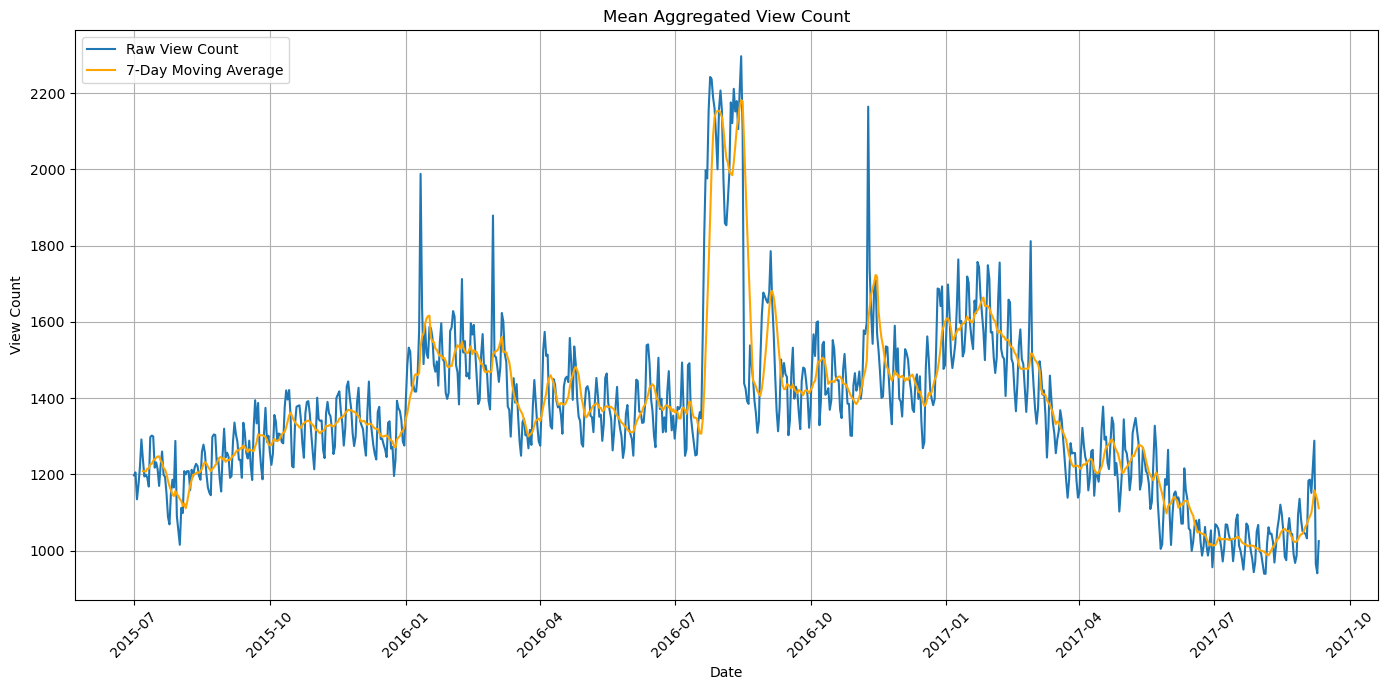

In [20]:
# Aggregate the view counts across all pages by taking mean
mean_aggregated_data = data_melted.groupby('Date')['View_Count'].mean()

plot_time_series(mean_aggregated_data, date_columns=None, aggregated=True, title='Mean Aggregated View Count')

- **Similar Seasonal Trends**: Like the sum plot, seasonal trends are evident, with peaks around mid-year.
- **Less Volatility**: The mean aggregation shows less extreme spikes compared to the sum aggregation, which can be attributed to averaging out extreme values.
- **Trend Visibility**: The moving average trend is smoother and easier to interpret.



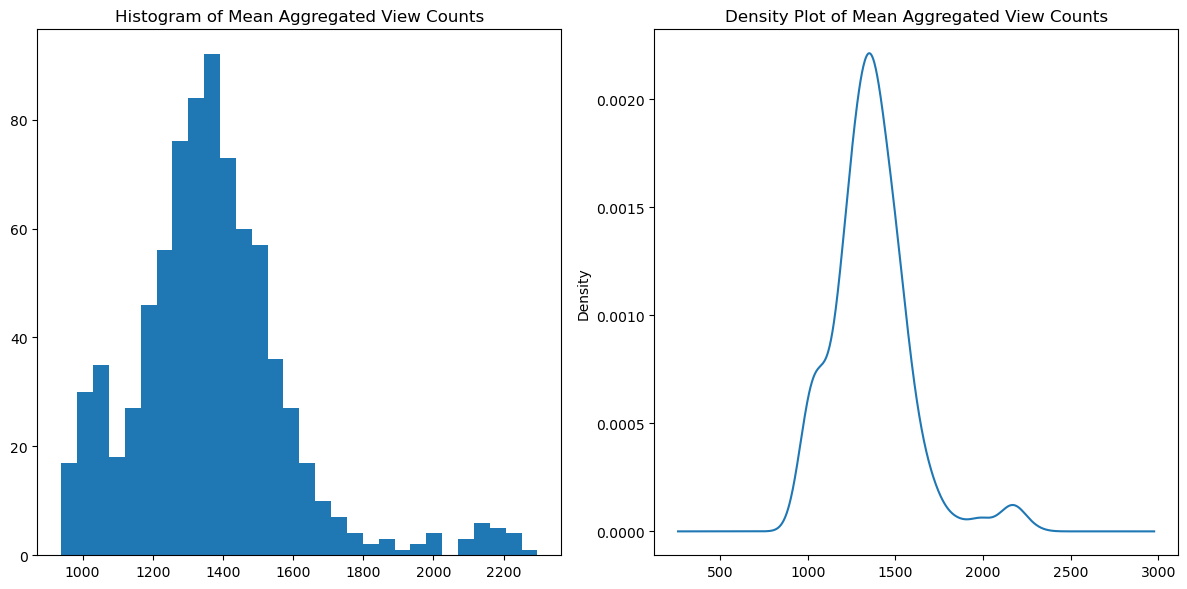

In [116]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(mean_aggregated_data, bins=30)
plt.title('Histogram of Mean Aggregated View Counts')
plt.subplot(122)
mean_aggregated_data.plot(kind='kde')
plt.title('Density Plot of Mean Aggregated View Counts')
plt.tight_layout()
plt.show()

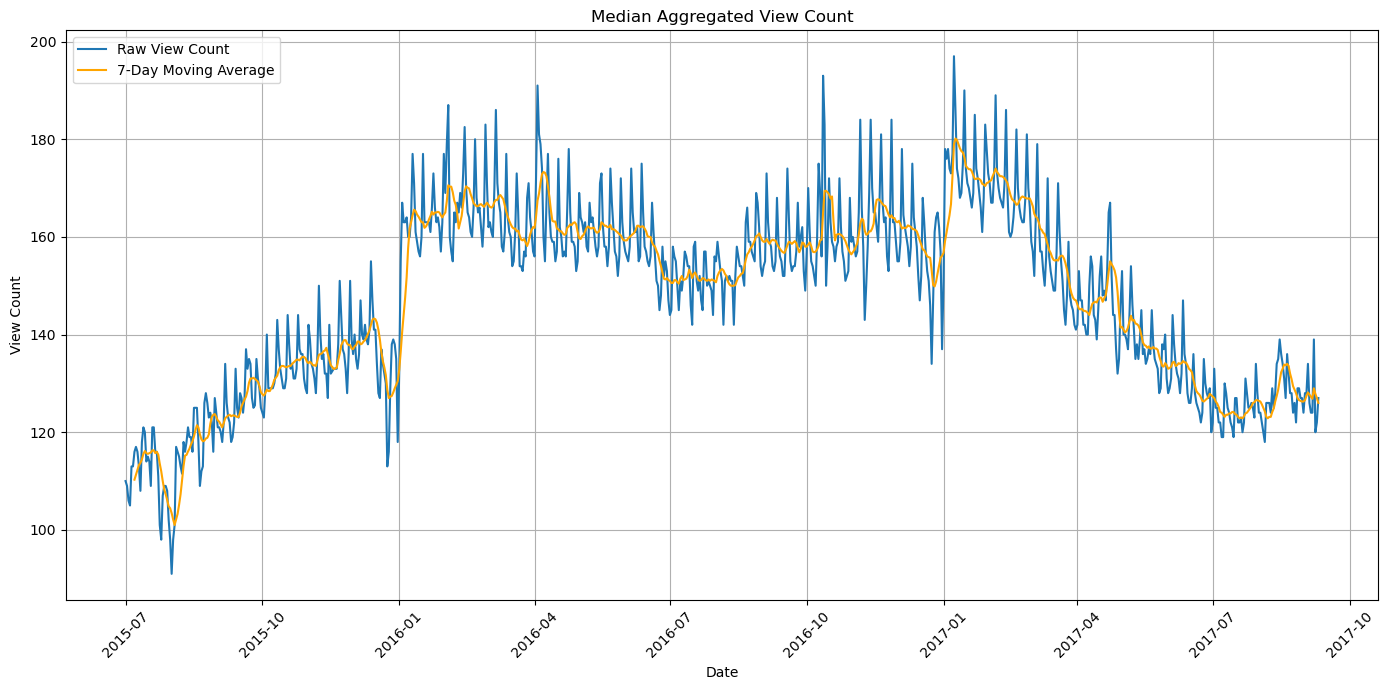

In [21]:
# Aggregate the view counts across all pages by taking median to exclude the influence of outliers
median_aggregated_data = data_melted.groupby('Date')['View_Count'].median()

plot_time_series(median_aggregated_data, date_columns=None, aggregated=True, title='Median Aggregated View Count')

- **Trend Representation**: The median aggregation highlights the central tendency, mitigating the impact of outliers.
- **Seasonal Patterns**: Seasonal trends are still visible, though less pronounced than in the mean and sum aggregations.
- **Stable Trends**: The median plot shows a more stable trend, reflecting typical behavior across articles without the influence of extreme values.


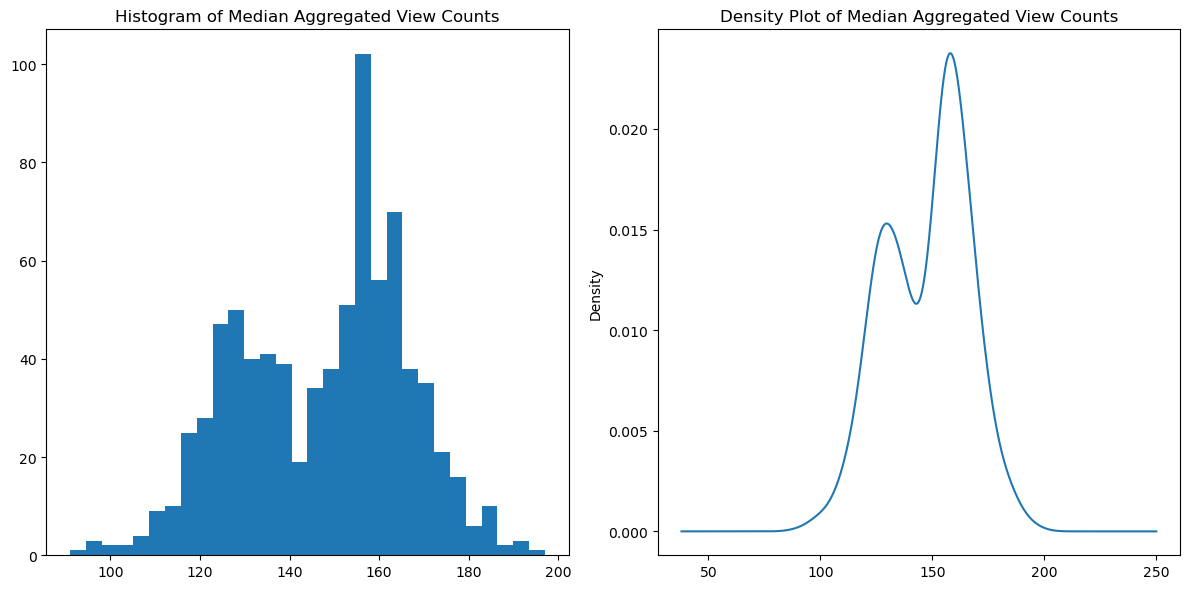

In [117]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(median_aggregated_data, bins=30)
plt.title('Histogram of Median Aggregated View Counts')
plt.subplot(122)
median_aggregated_data.plot(kind='kde')
plt.title('Density Plot of Median Aggregated View Counts')
plt.tight_layout()
plt.show()

- **Seasonal Variations**: All three plots highlight consistent seasonal variations in view counts, indicating regular patterns in user behavior.
- **Trend Smoothing**: The 7-day moving average effectively smooths short-term fluctuations, making long-term trends more apparent.
- **Aggregation Comparison**: Comparing sum, mean, and median aggregations provides a comprehensive view of the data, with each method offering unique insights. The sum aggregation highlights total interest, the mean shows average behavior, and the median focuses on typical behavior, reducing the influence of outliers.

### Rolling Statistics

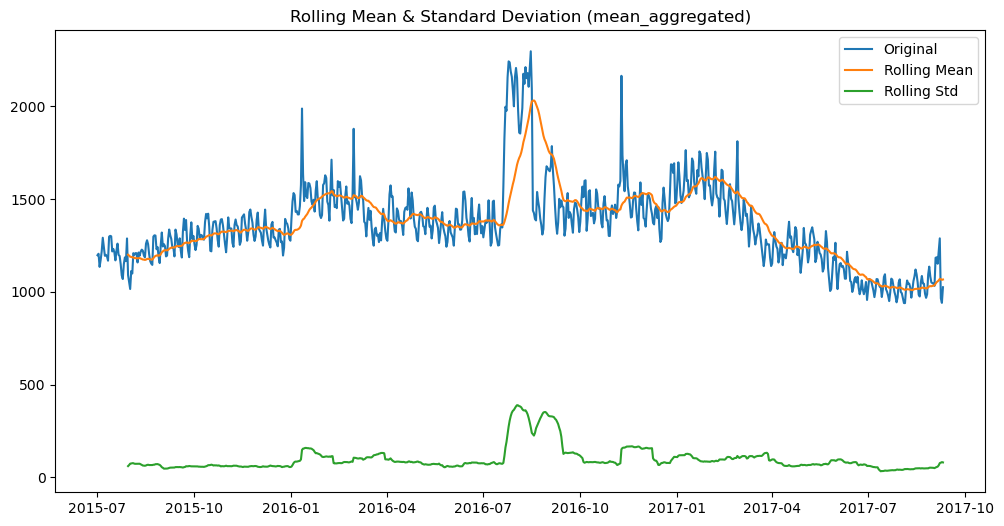

In [124]:
def plot_rolling_statistics(series, window=30, type_of_agg='mean'):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation ({type_of_agg}_aggregated)')
    plt.show()

plot_rolling_statistics(mean_aggregated_data, type_of_agg='mean')

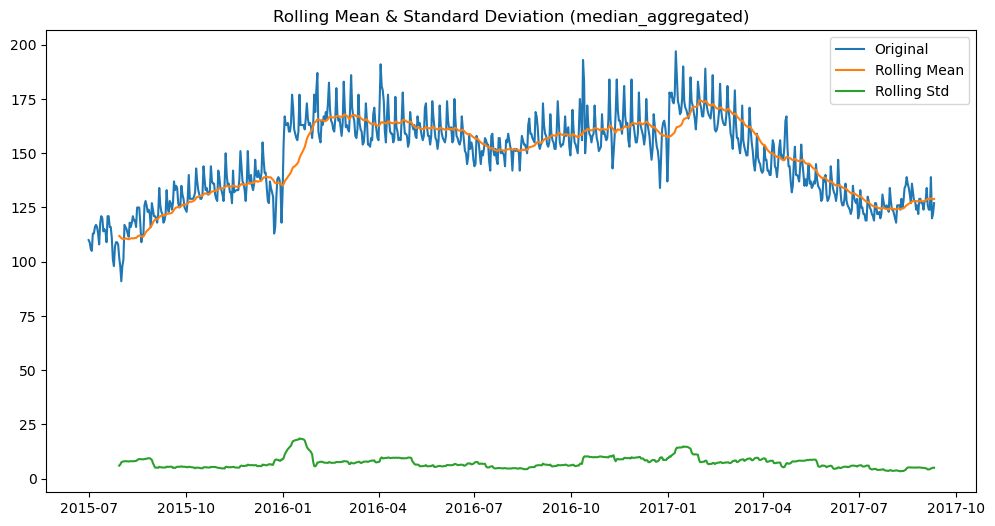

In [125]:
plot_rolling_statistics(median_aggregated_data, type_of_agg='median')

#### Mean Aggregated Data
- **Rolling Mean**: 
  - Shows an increasing trend from late 2015, peaking around mid-2016, and declining towards late 2016 and 2017.
  - Indicates a period of heightened interest followed by a gradual decline.
- **Rolling Standard Deviation**: 
  - Increased variability around mid-2016, suggesting significant fluctuations in viewership during peak periods.
  - Higher variability likely influenced by outliers or extreme values.

#### Median Aggregated Data
- **Rolling Mean**: 
  - Similar trend as the mean aggregated data, with an increase leading up to mid-2016 and a decline thereafter.
  - Consistent pattern of interest.
- **Rolling Standard Deviation**: 
  - Lower variability compared to the mean aggregated data.
  - Indicates more stable viewership patterns with fewer extreme spikes.
  - Lower variability suggests less influence from outliers or extreme values.

### Autocorrelation Plot

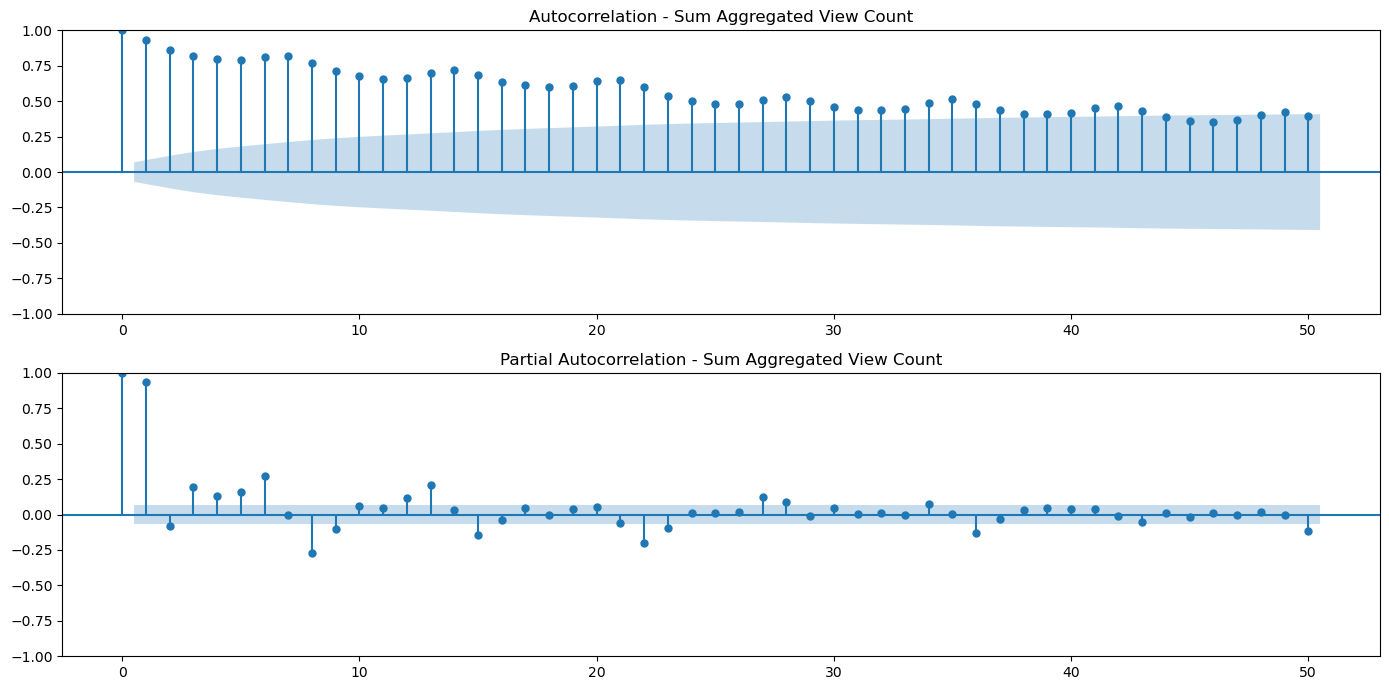

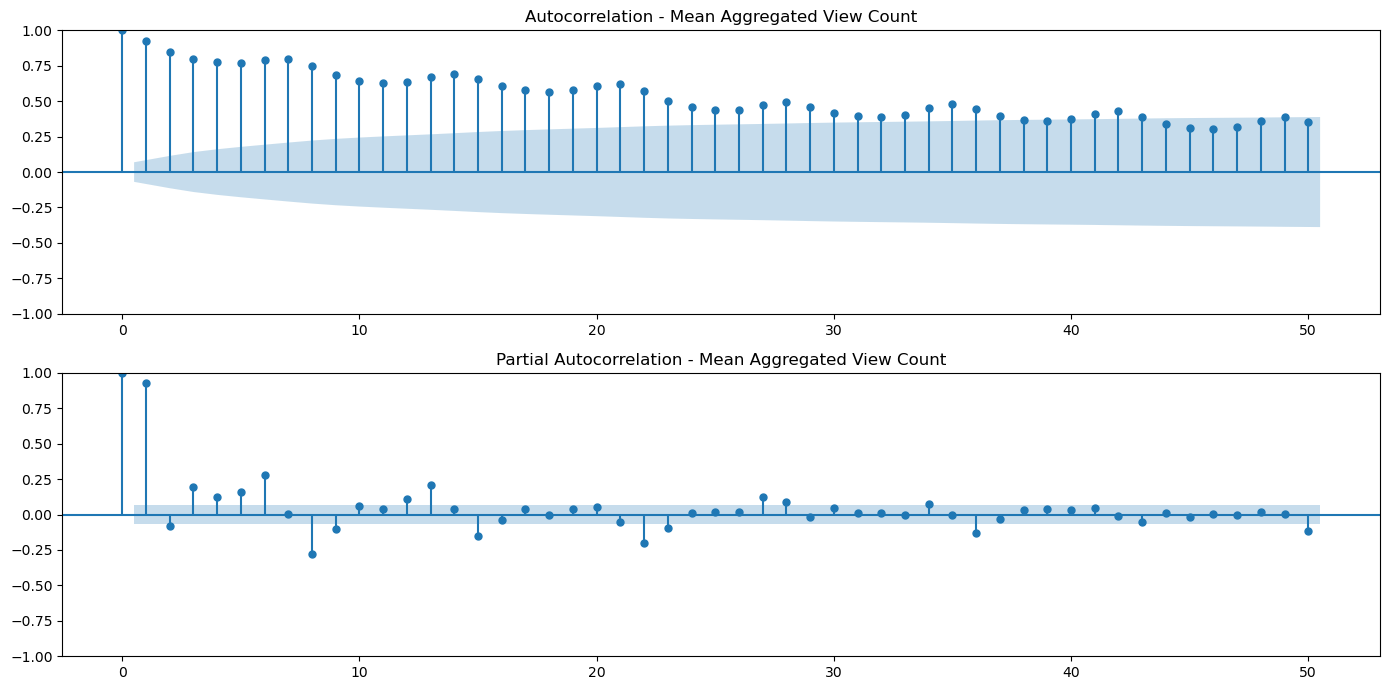

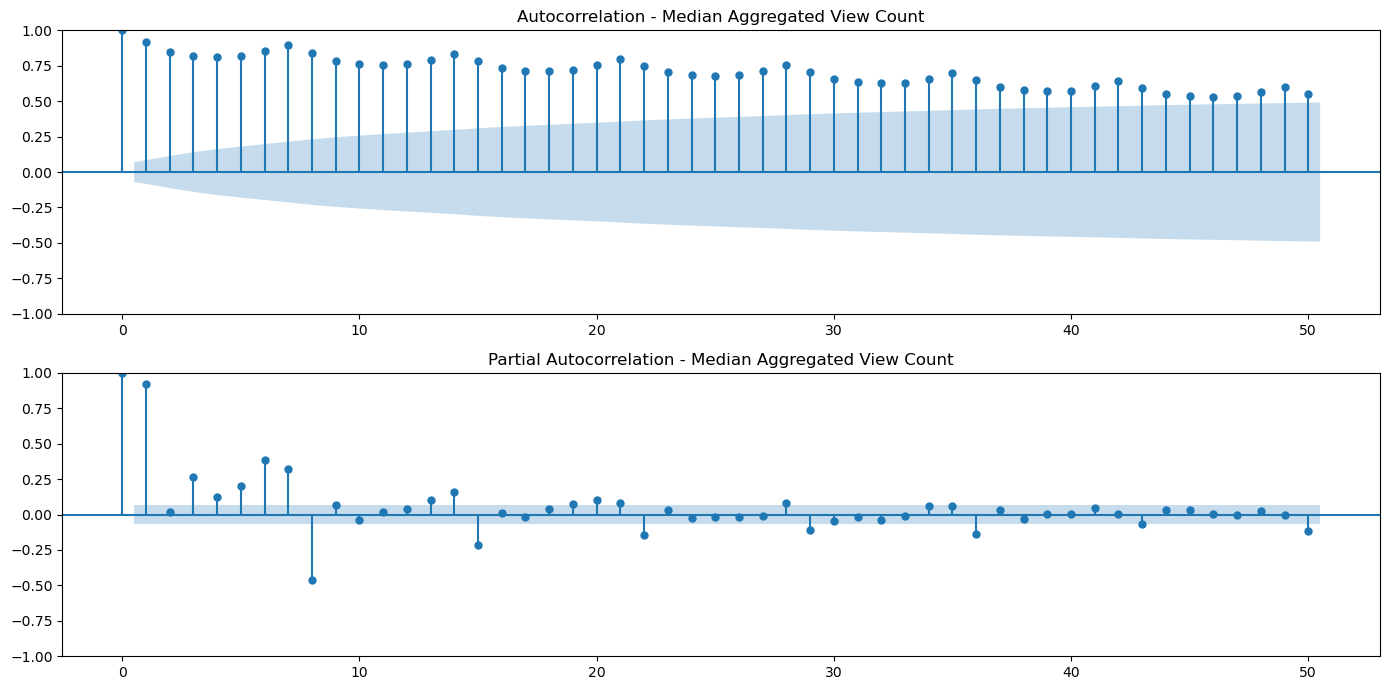

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_autocorrelation(data, lags=50, title=''):
    """
    Plots the autocorrelation and partial autocorrelation for the given data.
    
    Parameters:
        data (Series): The time series data for which to plot the autocorrelation.
        lags (int): Number of lags to display in the plot.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 7))
    
    # Autocorrelation plot
    plt.subplot(211)
    plot_acf(data, lags=lags, ax=plt.gca())
    plt.title(f'Autocorrelation - {title}')
    
    # Partial Autocorrelation plot
    plt.subplot(212)
    plot_pacf(data, lags=lags, ax=plt.gca())
    plt.title(f'Partial Autocorrelation - {title}')
    
    plt.tight_layout()
    plt.show()


plot_autocorrelation(sum_aggregated_data, title='Sum Aggregated View Count')
plot_autocorrelation(mean_aggregated_data, title='Mean Aggregated View Count')
plot_autocorrelation(median_aggregated_data, title='Median Aggregated View Count')

### Sum Aggregated View Count
- **Autocorrelation**: The autocorrelation plot for the sum aggregated view count shows significant positive autocorrelation at various lags, gradually decreasing as the lag increases. This indicates a strong correlation between the sum of view counts and their previous values over time.
- **Partial Autocorrelation**: The partial autocorrelation plot shows a significant spike at lag 1, indicating that the immediate previous value has a strong influence on the current value. Subsequent lags show diminishing partial correlations, suggesting that beyond the first lag, the influence of previous values is less pronounced but still present.

### Mean Aggregated View Count
- **Autocorrelation**: Similar to the sum aggregation, the autocorrelation plot for the mean aggregated view count shows significant positive autocorrelation, though the values are slightly lower. This suggests that the mean view counts also have a strong dependency on their past values.
- **Partial Autocorrelation**: The partial autocorrelation plot shows a significant spike at lag 1, followed by smaller spikes at other lags. This pattern indicates that while the immediate previous mean view count strongly influences the current value, other lagged values also contribute but to a lesser extent.

### Median Aggregated View Count
- **Autocorrelation**: The autocorrelation plot for the median aggregated view count exhibits a similar pattern, with significant positive autocorrelation that decreases with increasing lag. This suggests that the median view counts also depend on their past values.
- **Partial Autocorrelation**: The partial autocorrelation plot shows a significant spike at lag 1, followed by smaller, less pronounced spikes at higher lags. This indicates that the immediate previous median view count strongly influences the current value, with other lagged values having a lesser impact.

### Overall Insights
- **Lagged Dependencies**: All three plots (sum, mean, and median) exhibit significant autocorrelation, confirming the presence of strong lagged dependencies in the data. This is indicative of the seasonal and trend components inherent in the view counts.
- **Model Implications**: The significant spikes at lag 1 in the partial autocorrelation plots suggest that autoregressive models (such as ARIMA) would be suitable for forecasting, as the immediate past values are highly informative of the current values.

### Seasonal Decomposition

Decompose the time series into trend, seasonal, and residual components. This can provide insights into the underlying patterns and help in selecting appropriate forecasting models.

**Using sum aggregation**:
- Comprehensive Insight: Sum aggregation gives an overall picture of the total activity, which is useful for understanding the collective behavior of view counts across all pages.
- Trend Analysis: It allows for identifying long-term trends and seasonal patterns in the total activity, which is crucial for planning and forecasting.
- Model Suitability: Seasonal decomposition of the sum helps in selecting appropriate forecasting models that can handle aggregated data effectively.

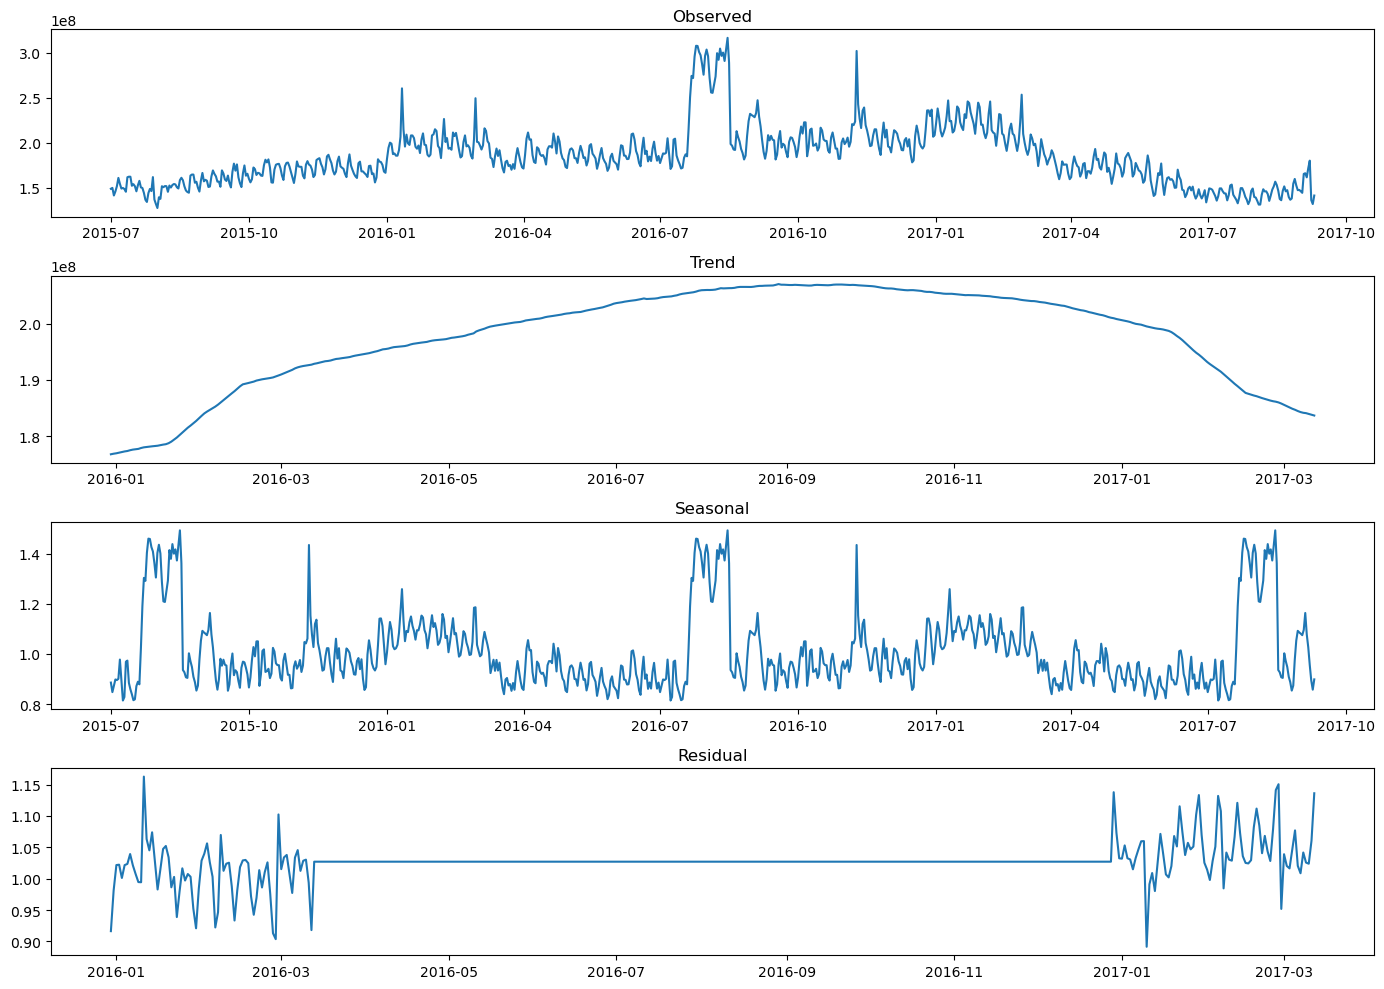

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decompose(data, model='multiplicative', freq=365):
    """
    Decomposes the time series data into trend, seasonal, and residual components and plots them.
    
    Parameters:
        data (Series): The time series data to decompose.
        model (str): The type of decomposition ('additive' or 'multiplicative').
        freq (int): The frequency of the seasonal component.
    """
    decomposition = seasonal_decompose(data, model=model, period=freq)

    plt.figure(figsize=(14, 10))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal')
    
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residual')
    
    plt.tight_layout()
    plt.show()

plot_seasonal_decompose(sum_aggregated_data, model='multiplicative')

**Observed**: The observed time series represents the actual view counts over time. It shows noticeable peaks and troughs, with significant increases around mid-2016 and subsequent declines. There are clear seasonal patterns and occasional spikes, indicating periods of higher activity.

**Trend**: The trend component shows the long-term movement of the time series. Here, the trend indicates:
- An initial increase in view counts from early 2016 until around mid-2016.
- A gradual decline from mid-2016 to early 2017.
- This suggests an overall upward trend in the first half of the period, followed by a downward trend.

**Seasonal**: The seasonal component captures the repeating patterns or cycles within the time series.
- The seasonal plot indicates regular fluctuations that repeat annually.
- There are higher values during mid-year and lower values towards the end of the year.
- This suggests a strong seasonal effect, where certain times of the year consistently see higher or lower activity.

**Residual**: The residual component represents the noise or random variation left after removing the trend and seasonal components.
- The residuals appear relatively stable for most of the period but show some spikes towards the end of the period.
- This indicates that most of the variation in the data can be explained by the trend and seasonal components, with some remaining unexplained variability.

Overall Insights
- Seasonality and Trend: The decomposition confirms strong seasonal patterns and a noticeable trend in the data. Understanding these components is crucial for accurate forecasting.
- Model Selection: The presence of significant seasonal and trend components suggests that models capable of handling seasonality (such as SARIMA or seasonal decomposition of time series forecasting models) would be appropriate.
- Residuals: Analyzing residuals can help improve model accuracy by addressing any unexplained variations. If residuals show patterns, further investigation or model refinement might be needed.

### Stationarity Check

Let's check if our time series data is stationary. Non-stationary data can affect the performance of forecasting models. 

Let's use the Augmented Dickey-Fuller (ADF) test to check for stationarity.

In [24]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

print('Sum Aggrgated Data')
print('**********')
check_stationarity(sum_aggregated_data)
print('Mean Aggrgated Data')
print('**********')
check_stationarity(mean_aggregated_data)
print('Median Aggrgated Data')
print('**********')
check_stationarity(median_aggregated_data)

Sum Aggrgated Data
**********
ADF Statistic: -2.646386
p-value: 0.083784
Critical Values:
   1%, -3.438750669890019
Critical Values:
   5%, -2.8652477937238703
Critical Values:
   10%, -2.56874438754281
Mean Aggrgated Data
**********
ADF Statistic: -2.673411
p-value: 0.078753
Critical Values:
   1%, -3.438750669890019
Critical Values:
   5%, -2.8652477937238703
Critical Values:
   10%, -2.56874438754281
Median Aggrgated Data
**********
ADF Statistic: -1.665846
p-value: 0.448790
Critical Values:
   1%, -3.438750669890019
Critical Values:
   5%, -2.8652477937238703
Critical Values:
   10%, -2.56874438754281


**Non-Stationarity**: All three aggregated data sets (sum, mean, and median) are non-stationary based on the ADF test results. This means that their statistical properties (mean, variance) change over time, and they are not suitable for many time series models without transformation.

**Next Steps**: To proceed with time series modeling, transformations such as differencing or detrending will be necessary to achieve stationarity. This will allow the use of models that assume a stationary time series.

### Outlier Detection

In [25]:
import numpy as np

def detect_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    outliers = np.abs(z_scores) > threshold
    return outliers

outliers = detect_outliers(sum_aggregated_data)
sum_aggregated_data[outliers]

Date
2016-07-24    295869411.0
2016-07-25    307944138.0
2016-07-26    307736239.0
2016-07-27    301059655.0
2016-07-28    297473150.0
2016-07-29    287636274.0
2016-07-31    296755164.0
2016-08-01    303737298.0
2016-08-02    296365296.0
2016-08-08    299711573.0
2016-08-09    292308300.0
2016-08-10    304802164.0
2016-08-11    296715759.0
2016-08-12    300370421.0
2016-08-13    291035681.0
2016-08-14    304136580.0
2016-08-15    316797418.0
2016-08-16    288937110.0
2016-11-09    302179887.0
Name: View_Count, dtype: float64

Most of the outliers are concentrated in a specific period between late July 2016 and mid-August 2016. There is also a notable outlier on November 9, 2016.

**Potential Causes**: These spikes in view counts could be due to various factors such as:
- Major events or news articles that caused a surge in traffic.
- Seasonal or periodic spikes in interest.
- Anomalies or errors in data collection.

### Correlation Analysis: Check for correlations between different articles' view counts

In [104]:
data.dropna().groupby(['main_domain', 'locale', 'access', 'agent']).size().reset_index(name='count').iloc[8:15, :]

,main_domain,locale,access,agent,count
8,wikipedia,de,all-access,all-agents,4021
9,wikipedia,de,all-access,spider,4021
10,wikipedia,de,desktop,all-agents,3756
11,wikipedia,de,mobile-web,all-agents,4347
12,wikipedia,en,all-access,all-agents,4106
13,wikipedia,en,all-access,spider,4225
14,wikipedia,en,desktop,all-agents,4209


In [92]:
data_wo_nan = data.dropna()
subset = data_wo_nan[
    (data_wo_nan['main_domain'] == 'wikipedia') & 
    (data_wo_nan['locale'] == 'en') &
    (data_wo_nan['access'] == 'mobile-web') &
    (data_wo_nan['agent'] == 'all-agents')
]

pivot_data = subset[['article'] + date_columns.to_list()].set_index('article').T
pivot_data.index = pd.to_datetime(pivot_data.index)
pivot_data.shape

(803, 4140)

In [93]:
correlation_matrix = pivot_data.corr()

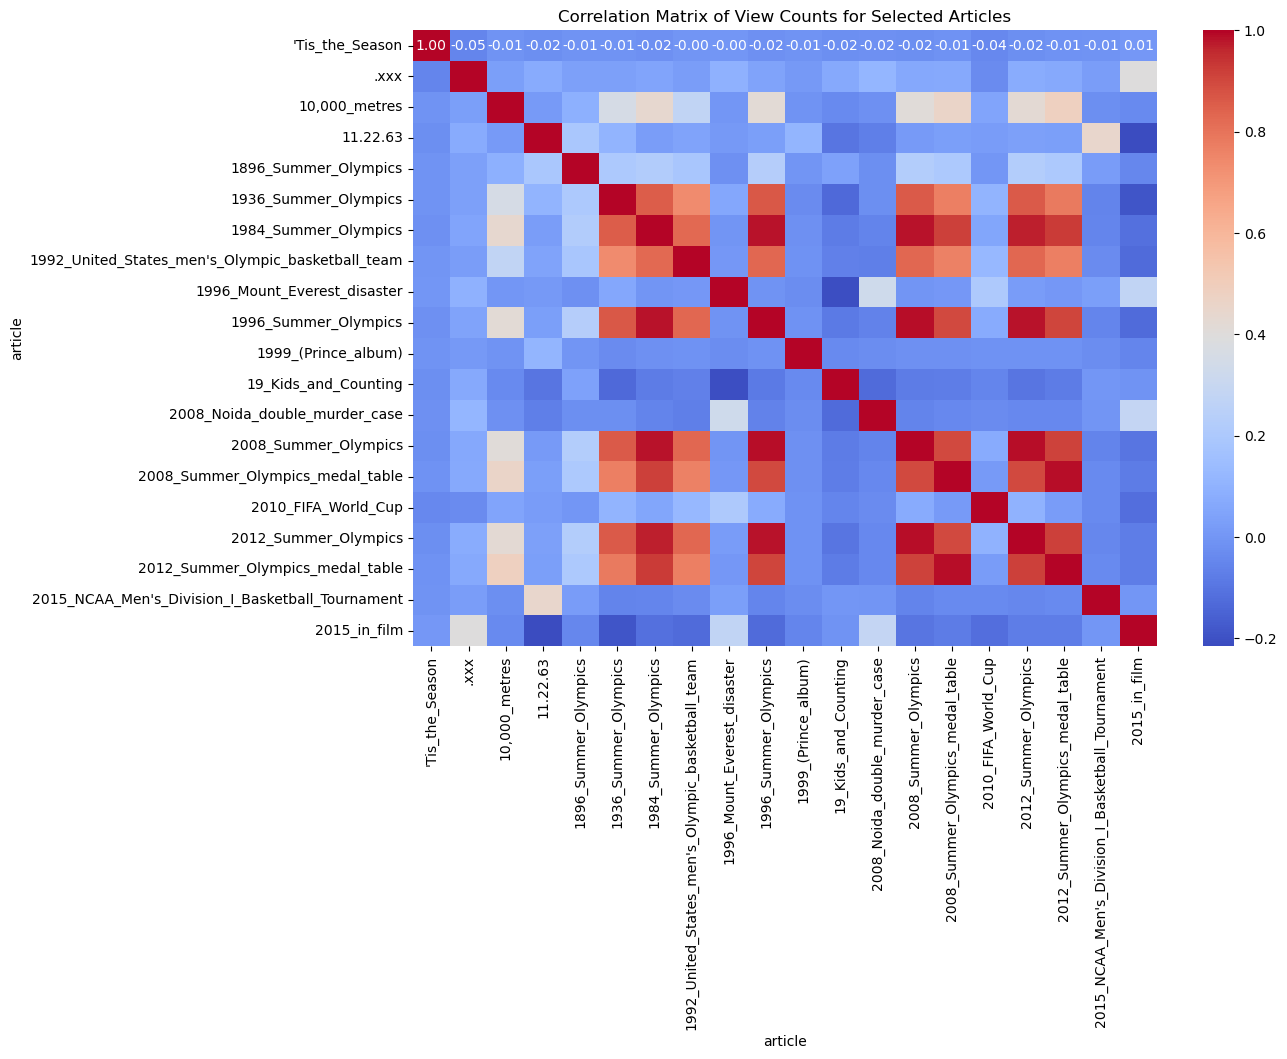

In [96]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.iloc[:20, :20], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of View Counts for Selected Articles')
plt.show()

**Clusters of Correlated Articles**: 
We can see clusters of articles that have high positive correlations with each other. These clusters might represent articles that are related in content or are commonly viewed together.

- Articles related to different years of the Summer Olympics show high correlations with each other (e.g., 1992_United_States_men's_Olympic_basketball_team, 1984_Summer_Olympics, 2008_Summer_Olympics).
- Articles related to the Summer Olympics across different years exhibit similar viewership patterns, suggesting that interest in the Olympics tends to cluster around specific periods.

- Many articles show little to no correlation with each other (indicated by the white or light blue shades), implying that their viewership patterns are independent.

**Outliers**: If there are any articles with a pattern of unique correlations (either very high positive or negative with multiple others), they might represent outliers or articles that drive unique traffic patterns.

**General Trends**: The overall color distribution can give us a sense of how interconnected the view counts of articles are within our selected subset.

In [101]:
sample_article = '1936_Summer_Olympics'
correlations = correlation_matrix.loc[sample_article].copy()
correlations[sample_article] = -1
most_correlated_article = correlations.idxmax()
max_correlation_value = correlations.max()
print(f"The most correlated article to '{sample_article}' is '{most_correlated_article}' with a correlation of {max_correlation_value:.2f}")

The most correlated article to '1936_Summer_Olympics' is '2016_Summer_Olympics' with a correlation of 0.88


Seasonal Decompose of Article: 1936_Summer_Olympics
---------------------------------------------------


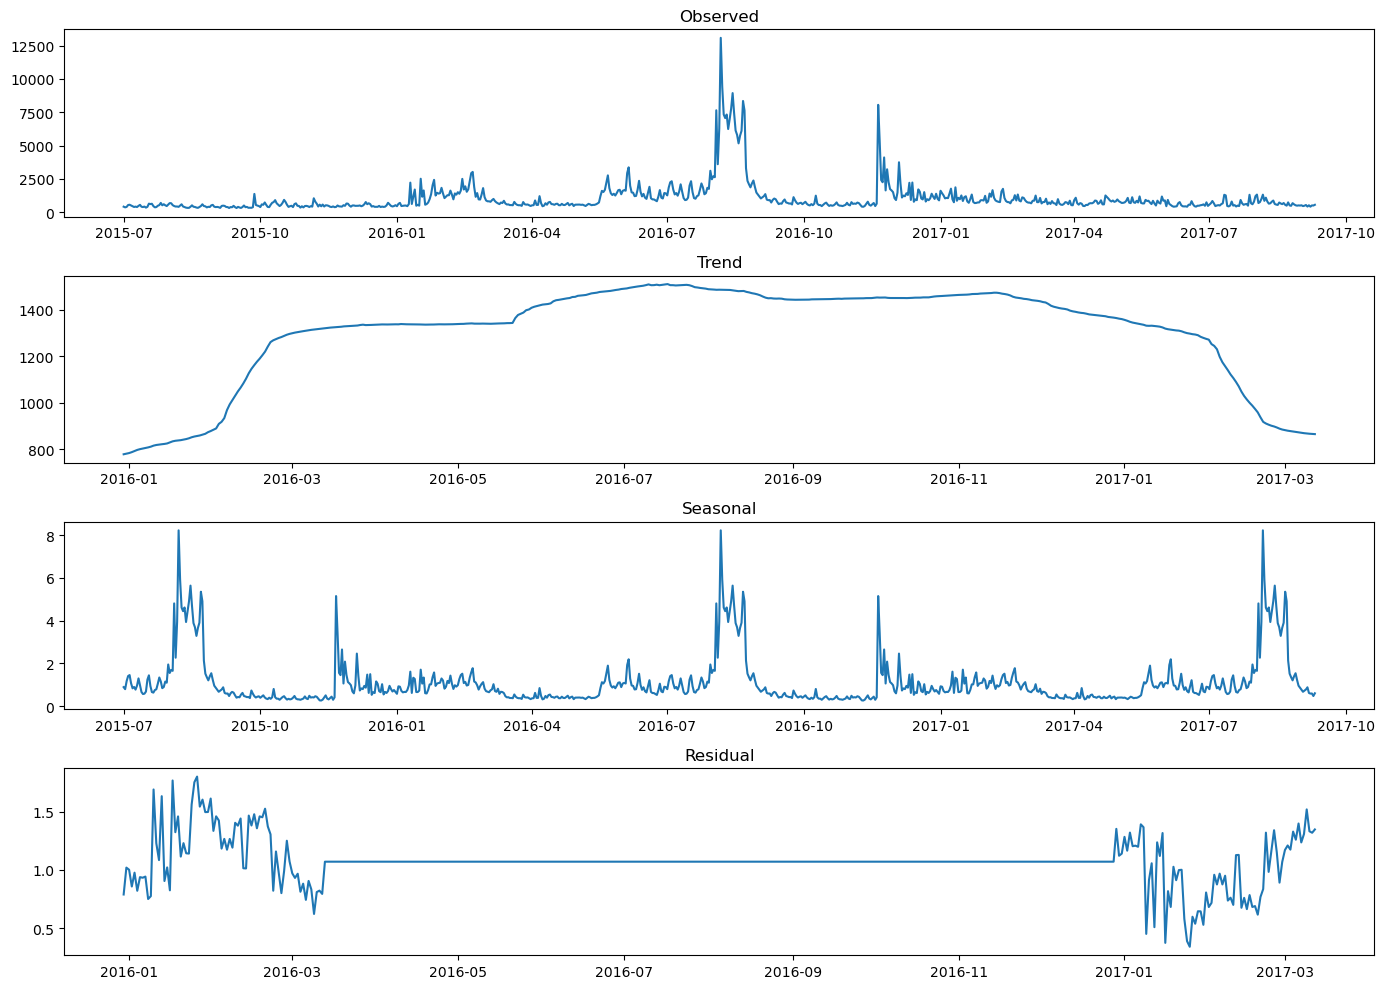

Seasonal Decompose of Article: 2016_Summer_Olympics
---------------------------------------------------


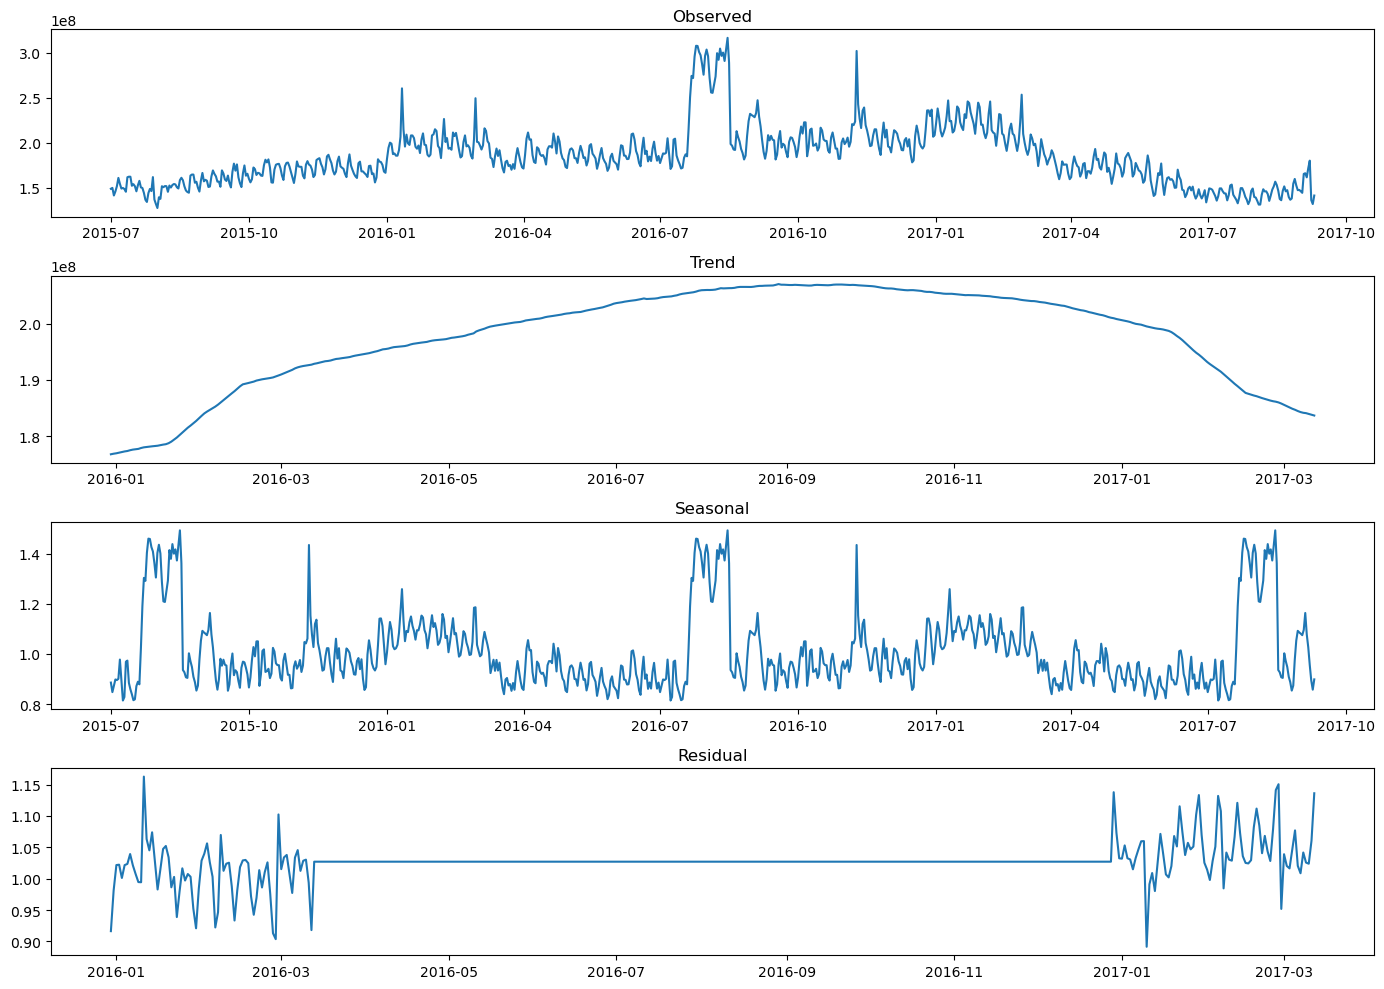

In [103]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
print('Seasonal Decompose of Article: 1936_Summer_Olympics')
print('---------------------------------------------------')
article_name = '1936_Summer_Olympics'
article_series = pivot_data[article_name]
article_series = pd.Series(article_series.values, index=pd.to_datetime(article_series.index))
plot_seasonal_decompose(article_series, model='multiplicative')


print('Seasonal Decompose of Article: 2016_Summer_Olympics')
print('---------------------------------------------------')
article_name = '2016_Summer_Olympics'
article_series = pivot_data[article_name]
article_series = pd.Series(article_series.values, index=pd.to_datetime(article_series.index))
plot_seasonal_decompose(sum_aggregated_data, model='multiplicative')

**Interest Patterns:**

- Both the 1936 and 2016 Summer Olympics articles show similar patterns of interest, with spikes around specific periods (likely anniversaries or the event dates themselves).

- The trend in both cases increases leading up to the key period and then declines, indicating a rise in interest that wanes after the event.

**Seasonality:**
Both articles exhibit strong seasonal patterns, although the seasonality for the 2016 Olympics is more aligned with the event dates, suggesting more immediate and pronounced interest during the event.

**Residuals:**
Residuals for both articles show higher variance during peak periods, indicating other factors at play that affect view counts unpredictably during these times.

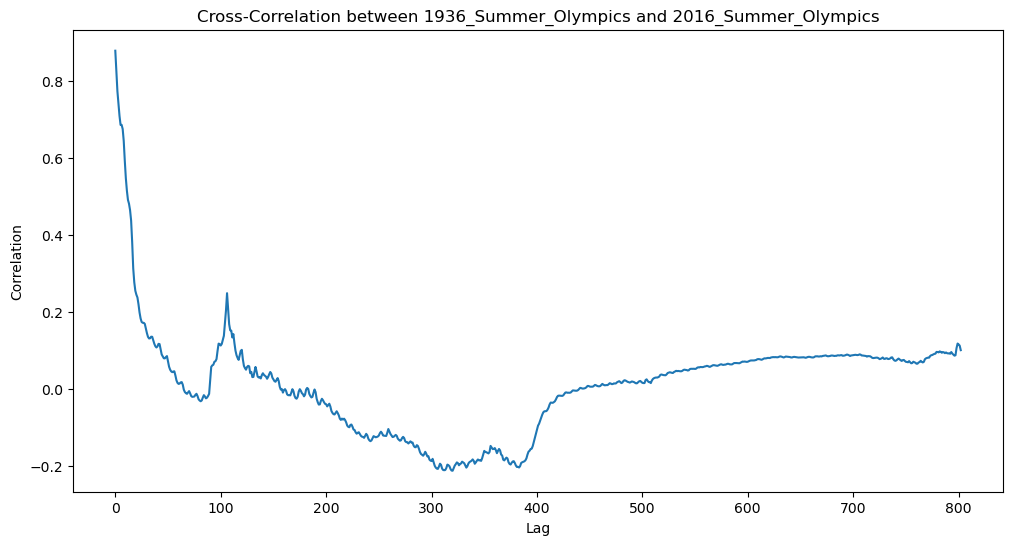

In [113]:
from statsmodels.tsa.stattools import ccf

series1 = subset.loc[subset['article'] == '1936_Summer_Olympics'][date_columns].T.squeeze()
series2 = subset.loc[subset['article'] == '2016_Summer_Olympics'][date_columns].T.squeeze()

cross_corr = ccf(series1, series2)
plt.figure(figsize=(12, 6))
plt.plot(cross_corr)
plt.title('Cross-Correlation between 1936_Summer_Olympics and 2016_Summer_Olympics')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()


1. High Initial Correlation (Lag 0):

* At lag 0, the correlation is high (~0.8), indicating that the view counts for both articles move together strongly at the same time.

2. Rapid Decline:
* The correlation quickly decreases as the lag increases, suggesting that the immediate relationship weakens over time.

3. Secondary Peak:
* A secondary peak around lag 100 might indicate periodic or delayed interest patterns, where events related to one Olympics may trigger interest in the other after some delay.

4. Potential Delayed Interest:
The secondary peak suggests that there could be a delayed interest where significant events or anniversaries related to the 1936 Olympics might influence the view counts for the 2016 Olympics after a certain period.

5. Long-term Trend:
* Beyond lag 300, the correlation remains low but slightly positive, indicating a weak long-term relationship between the two articles.

## Check if they are currently active

In [1]:
# import aiohttp
# import asyncio
# import nest_asyncio
# nest_asyncio.apply()

# async def custom_quote(article):
#     symbols_to_encode = ['%', '/', '?', "'", '"', '&', '=', '#']
#     for symbol in symbols_to_encode:
#         article = article.replace(symbol, quote(symbol))
#     return article

# async def build_page_url(domain=None, article=None, full_page_name=None):
#     if full_page_name:
#         article, domain, _, _, _ = extract_page_components(full_page_name)
#     elif not article or not domain:
#         raise ValueError("Provide valid input")
#     encoded_article = await custom_quote(article)
#     page_check_url = f'https://{domain}/wiki/{encoded_article}'
#     return page_check_url

# async def check_if_it_is_live(url, session):
#     headers = {
#         'User-Agent': 'Mozilla/5.0'
#     }
#     try:
#         async with session.head(url, headers=headers) as response:
#             return response.status
#     except aiohttp.ClientError as e:
#         print(f"Error checking URL {url}: {e}")
#         return None



# async def check_if_it_is_live(url, session, max_retries=5):
#     headers = {
#         'User-Agent': 'Mozilla/5.0'
#     }
#     retries = 0
#     while retries < max_retries:
#         try:
#             async with session.head(url, headers=headers) as response:
#                 if response.status == 429:
#                     retries += 1
#                     wait_time = 2 ** retries
#                     await asyncio.sleep(wait_time)
#                 else:
#                     return response.status
#         except aiohttp.ClientError as e:
#             print(f"Error checking URL {url}: {e}")
#             return None
#     return 429  # If all retries failed


# async def build_url_and_check_status(page_name, session):
#     url = await build_page_url(full_page_name=page_name)
#     status_code = await check_if_it_is_live(url, session)
#     return url, status_code

# async def parallel_check_pages_live_status(page_names):
#     async with aiohttp.ClientSession() as session:
#         tasks = [build_url_and_check_status(page_name, session) for page_name in page_names]
#         return await asyncio.gather(*tasks)

# page_names = data['page'].tolist()
# results = asyncio.get_event_loop().run_until_complete(parallel_check_pages_live_status(page_names))
# urls, status_codes = zip(*results)

# data['url'] = urls
# data['status_code'] = status_codes

In [2]:
# page_names = data[data['status_code'] == 429]['page'].tolist()
# results = asyncio.get_event_loop().run_until_complete(parallel_check_pages_live_status(page_names))
# urls, status_codes = zip(*results)

# subset_index = data[data['status_code'] == 429].index
# data.loc[subset_index, 'url'] = urls
# data.loc[subset_index, 'status_code'] = status_codes

In [3]:
# data['status_code'].value_counts()

In [4]:
# data['article'].nunique()

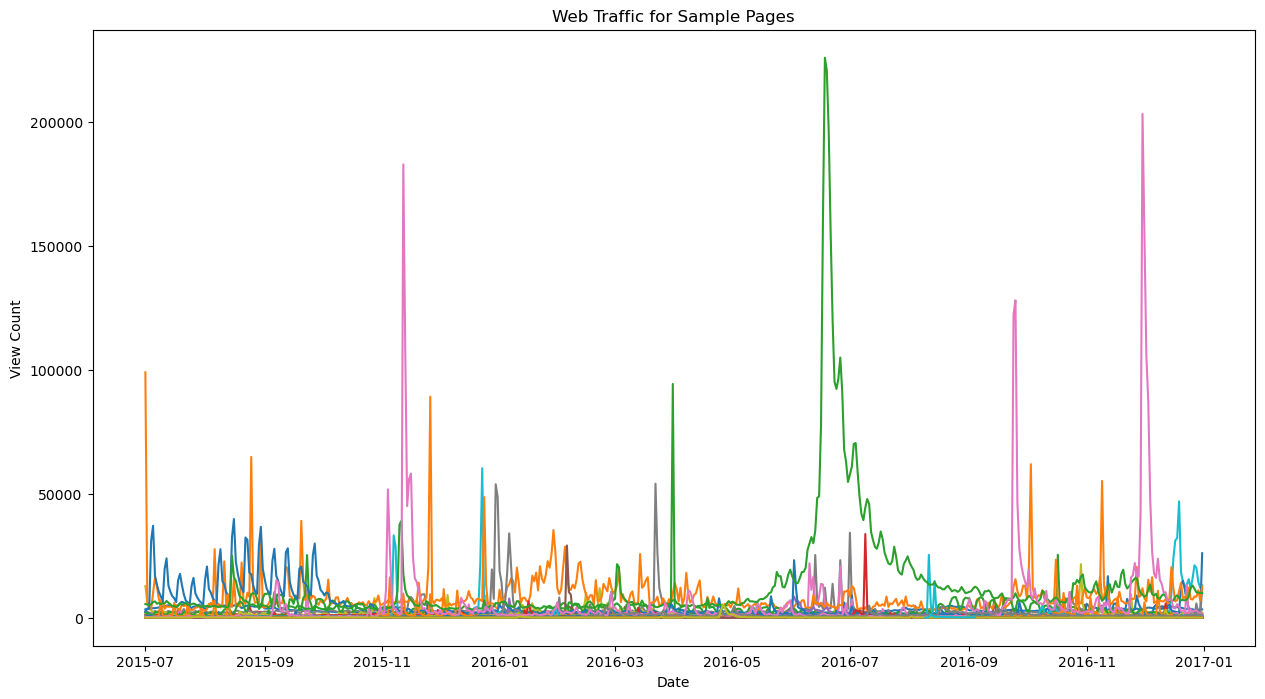

In [15]:
# Plotting the time series of a random sample of pages
sample_pages = train_data.sample(n=50, random_state=1)['Page']
sample_data = train_data[train_data['Page'].isin(sample_pages)]

# Plotting the time series for the sample pages
plt.figure(figsize=(15, 8))
for page in sample_pages:
    plt.plot(pd.to_datetime(train_data.columns[1:]), sample_data[sample_data['Page'] == page].iloc[:, 1:].T, label=page)

# plt.legend(loc='best')
plt.title('Web Traffic for Sample Pages')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.show()

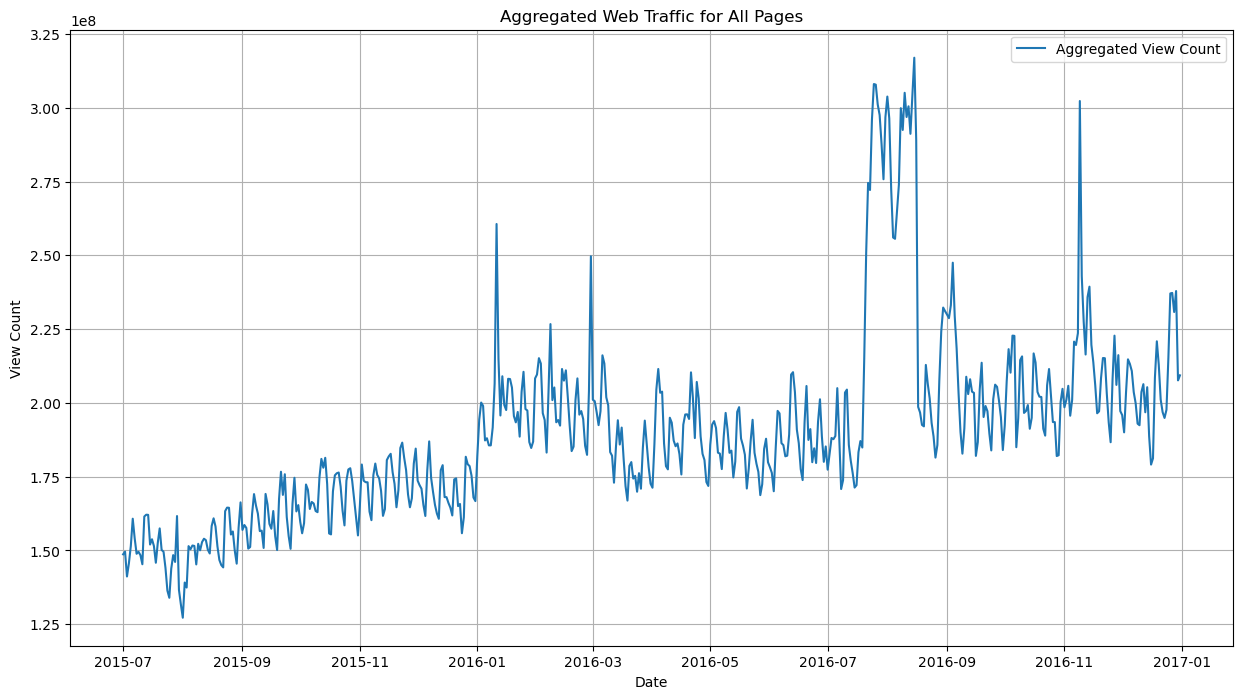

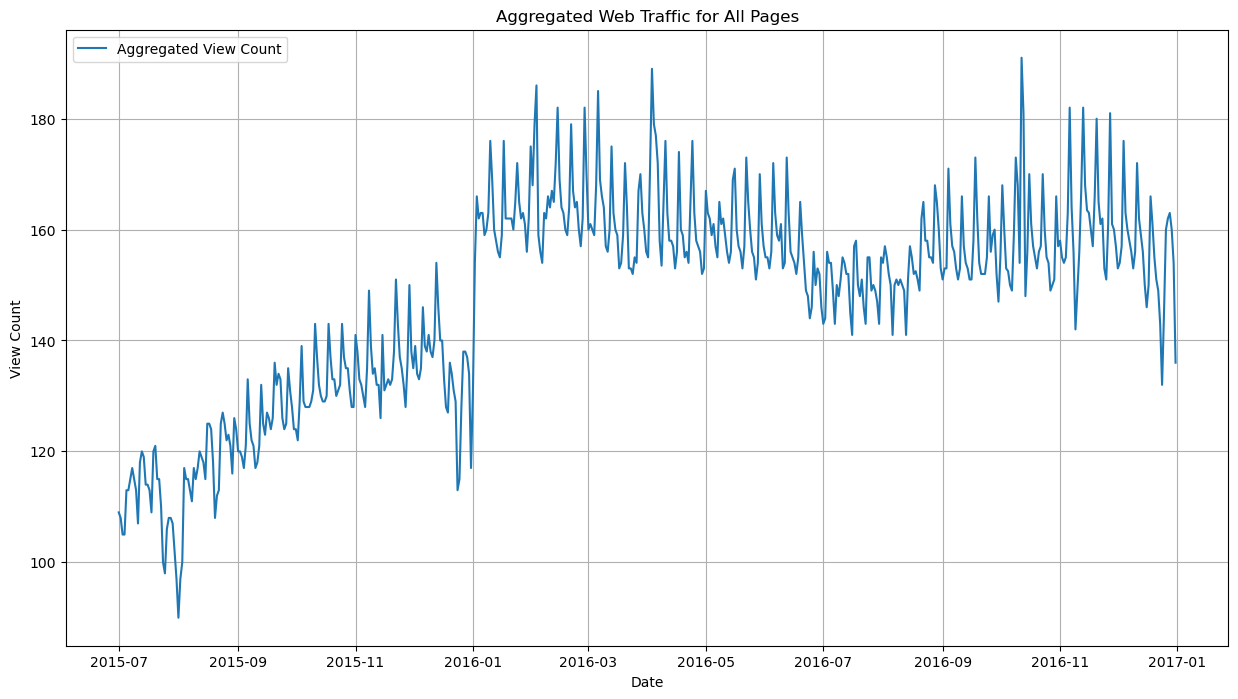

In [20]:
data_melted = train_data.melt(id_vars=['Page'], var_name='Date', value_name='View_Count')
data_melted['Date'] = pd.to_datetime(data_melted['Date'])

# Aggregate the view counts across all pages
aggregated_data = data_melted.groupby('Date')['View_Count'].median()

# Plot the aggregated view counts
plt.figure(figsize=(15, 8))
plt.plot(aggregated_data, label='Aggregated View Count')
plt.title('Aggregated Web Traffic for All Pages')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.grid(True)
plt.legend()
plt.show()

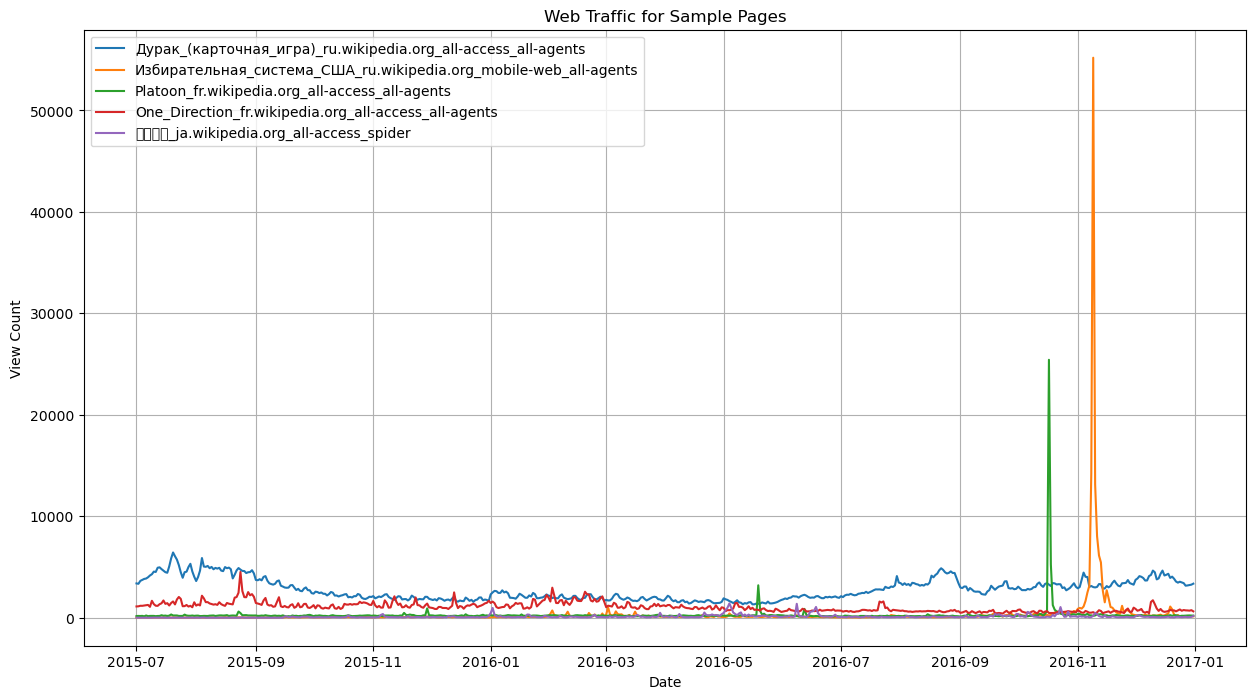

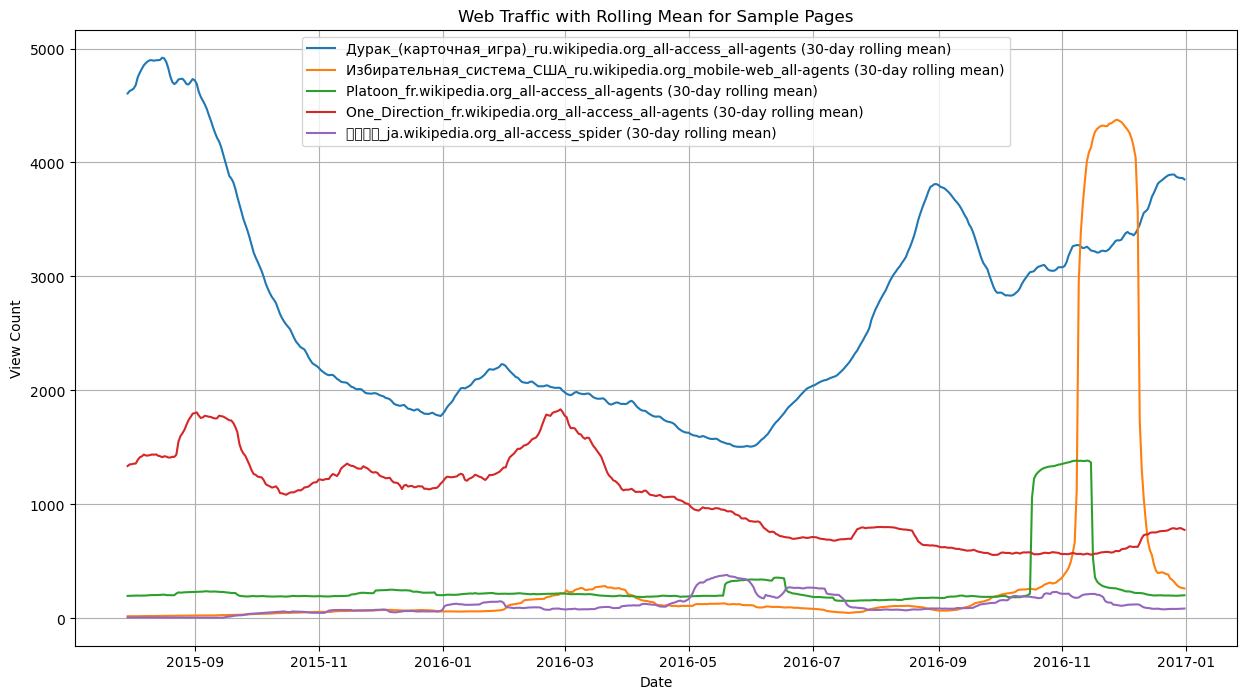

In [25]:
# Plotting the time series of a random sample of pages
sample_size = 5  # Number of pages to sample
sample_pages = train_data.sample(n=sample_size, random_state=1)['Page']
sample_data = train_data[train_data['Page'].isin(sample_pages)]

# Convert the dates to a proper datetime format
dates = pd.to_datetime(train_data.columns[1:])

plt.figure(figsize=(15, 8))

for page in sample_pages:
    page_data = sample_data[sample_data['Page'] == page].iloc[:, 1:].T
    page_data.index = dates
    plt.plot(page_data, label=page)

plt.legend(loc='best')
plt.title('Web Traffic for Sample Pages')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.grid(True)
plt.show()

# Adding a rolling mean to smooth the time series
plt.figure(figsize=(15, 8))

for page in sample_pages:
    page_data = sample_data[sample_data['Page'] == page].iloc[:, 1:].T
    page_data.index = dates
    rolling_mean = page_data.rolling(window=30).mean()
    plt.plot(rolling_mean, label=f'{page} (30-day rolling mean)')

plt.legend(loc='best')
plt.title('Web Traffic with Rolling Mean for Sample Pages')
plt.xlabel('Date')
plt.ylabel('View Count')
plt.grid(True)
plt.show()
